In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import explore, wrangle
from explore import rfe, split, select_kbest


In [ ]:
df = pd.read_csv('prepped_data.csv')
df.head()

,date,age,gender,race,city,state,zipcode,county,agency_responsible,cause_of_death,...,age_bins,unknown,under 12,12-17,18-24,25-34,35-44,45-54,55-64,65+
0,2013-01-01,26,male,white,mankato,mn,56001.0,blue earth,mankato department of public safety,taser,...,25-34,0,0,0,0,1,0,0,0,0
1,2013-01-01,31,male,black,omaha,ne,68111.0,douglas,omaha police department,gunshot,...,25-34,0,0,0,0,1,0,0,0,0
2,2013-01-01,26,male,hispanic,bakersfield,ca,93304.0,kern,bakersfield police department,gunshot,...,25-34,0,0,0,0,1,0,0,0,0
3,2013-01-01,21,male,white,gordon,wi,54838.0,douglas,douglas county sheriff's office,gunshot,...,18-24,0,0,0,1,0,0,0,0,0
4,2013-01-01,49,male,hispanic,farmington,nm,87401.0,san juan,farmington police department,gunshot,...,45-54,0,0,0,0,0,0,1,0,0


In [ ]:
# encode cause of death for ML
# cod_dummies = pd.get_dummies(df.cause_of_death, prefix='cod')

In [ ]:
# # concat dummy feats to df
# df = pd.concat([df, cod_dummies], axis =1)

In [ ]:
# # cleaning age
# df['age'] = np.where(df['age'].str.contains('s'), '', df.age)
# df['age'] = pd.to_numeric(np.where(df['age'].str.contains('Unknown'), 0, df.age))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8634 entries, 0 to 8633
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date                                         8634 non-null   object 
 1   age                                          8634 non-null   int64  
 2   gender                                       8634 non-null   object 
 3   race                                         8634 non-null   object 
 4   city                                         8634 non-null   object 
 5   state                                        8634 non-null   object 
 6   zipcode                                      8634 non-null   float64
 7   county                                       8634 non-null   object 
 8   agency_responsible                           8634 non-null   object 
 9   cause_of_death                               8634 non-null   object 
 10  

In [ ]:
# #Bin age as follows = ['under 12','12-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
# cut_labels_a = ['unknown', 'under 12','12-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
# cut_bins = [-1, 0, 11, 17, 24, 34, 44, 54, 64, 100]
# df['age_bins'] = pd.cut(df['age'], bins=cut_bins, labels=cut_labels_a)

# # make dummy columns for age range
# age_dummies = pd.get_dummies(df.age_bins, drop_first=False)

# #concat dummies to original dataframe
# df = pd.concat([df, age_dummies], axis=1)

In [ ]:
df.age.eq(13).sum() 

3

In [ ]:
ages = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
def agecheck(ages):
    sum = 0
    for i in ages:
        sum += df.age.eq(i).sum() 
    return sum

agecheck(ages)

2697

In [ ]:
df.age_bins.value_counts()

25-34       2697
35-44       2005
18-24       1289
45-54       1278
55-64        652
unknown      279
65+          267
12-17        155
under 12      12
Name: age_bins, dtype: int64

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


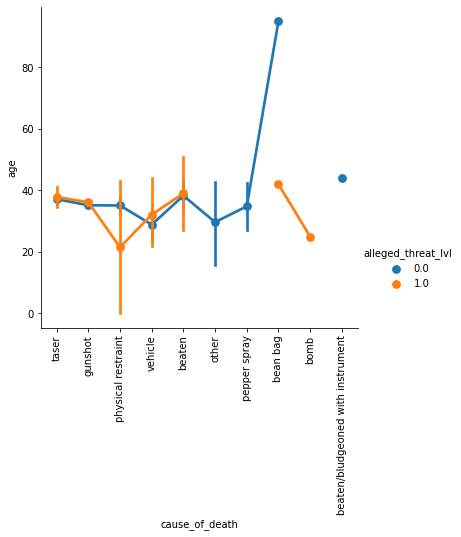

In [ ]:
sns.factorplot(x = "cause_of_death", y = 'age', hue = "alleged_threat_lvl",data = df)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
df.race.value_counts()

white                     3786
black                     2190
hispanic                  1526
unknown race               831
asian/pacific islander     183
native american            118
Name: race, dtype: int64

In [ ]:
df.shape

(8634, 61)

In [ ]:
df.mental_illness.value_counts()


no                     5580
yes                    1625
unknown                1108
drug or alcohol use     320
drug_alcohol_use          1
Name: mental_illness, dtype: int64

In [ ]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

def explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = freq_table(train, cat_var)
    plt.figure(figsize=(7,7))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen', edgecolor = 'darkblue')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(16,6))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen', edgecolor='darkblue')
    p = plt.title(quant_var)
    p = plt.xticks(rotation = 90)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    p = plt.xticks(rotation = 90)
    return p, descriptive_stats
    
def freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table

In [ ]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split

In [ ]:

def split_df(df, target, seed):
    '''
    split_df will take one argument(df) and 
    then split our data into 20/80, 
    then split the 80% into 30/70
    performs a train, validate, test split
    splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 6 dataframes and 3 series:
    train, validate, test split, X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # Train, Validate, and test
    train_and_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    train, validate = train_test_split(train_and_validate, test_size=0.3, random_state=seed)
    # Split with X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test 

In [ ]:

train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_df(df, 'alleged_threat_lvl', 42)

In [ ]:
ct = pd.crosstab(train.alleged_threat_lvl, train.cause_of_death)
ct

cause_of_death,bean bag,beaten,beaten/bludgeoned with instrument,bomb,gunshot,other,pepper spray,physical restraint,taser,vehicle
alleged_threat_lvl,,,,,,,,,,
0.0,0,16,1,0,2235,4,3,22,133,22
1.0,1,3,0,1,2355,0,0,2,32,4


H<sub>o</sub>: There is independence between the cause of death and civilian threat level. <br>
 H<sub>a</sub>: There is a dependent relationship between the cause of death and civilian threat level.

The **Chi<sup>2</sup> test** uses a contingency table test to compare two categorical variables to test the hypothesis that one group is independant of another.  


Because the p-value is less than alpha, we reject the null hypothesis.  We will move forward with the alternative hypothesis that there is a dependent relationship between the cause of death and the civilian threat level. 

In [ ]:
explore.chi2(train, 'cause_of_death', 'alleged_threat_lvl', alpha=0.05)

Observed

[[   0    1]
 [  16    3]
 [   1    0]
 [   0    1]
 [2235 2355]
 [   4    0]
 [   3    0]
 [  22    2]
 [ 133   32]
 [  22    4]]
---
Expected

[[5.03930492e-01 4.96069508e-01]
 [9.57467935e+00 9.42532065e+00]
 [5.03930492e-01 4.96069508e-01]
 [5.03930492e-01 4.96069508e-01]
 [2.31304096e+03 2.27695904e+03]
 [2.01572197e+00 1.98427803e+00]
 [1.51179148e+00 1.48820852e+00]
 [1.20943318e+01 1.19056682e+01]
 [8.31485312e+01 8.18514688e+01]
 [1.31021928e+01 1.28978072e+01]]
---

chi^2 = 112.6927
p     = 0.0000

Because the p-value: 0.0 is less than alpha: 0.05, we can reject the null hypothesis


<AxesSubplot:xlabel='alleged_threat_lvl', ylabel='Count'>

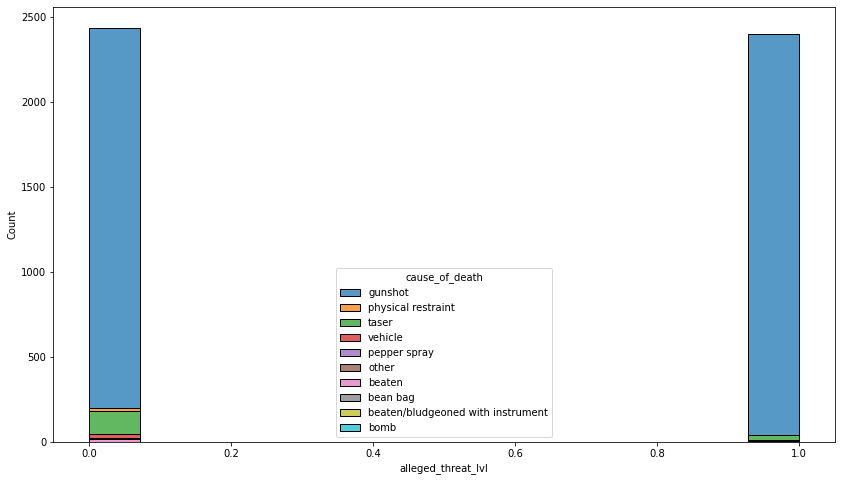

In [ ]:
plt.figure(figsize=(14, 8))
# hue_order = ['low_ach', 'avg_ach', 'high_ach']
sns.histplot(data=train, x="alleged_threat_lvl", hue = "cause_of_death", multiple="stack")

In [ ]:
train.columns

Index(['date', 'age', 'gender', 'race', 'city', 'state', 'zipcode', 'county',
       'agency_responsible', 'cause_of_death', 'description_of_circumstances',
       'official_disposition', 'criminal_charges_filed', 'mental_illness',
       'armed_unarmed_status', 'alleged_weapon', 'alleged_threat_lvl',
       'fleeing', 'body_camera', 'geography', 'encounter_type_draft',
       'initial_reported_reason_for_encounter_draft',
       'known_past_shootings_of_officer_draft', 'is_female', 'is_male',
       'is_transgender', 'was_fleeing', 'was_not fleeing ',
       'was_allegedly_armed', 'was_unarmed', 'was_vehicle',
       'was_domestic_disturbance', 'was_mental_health_welfare_check',
       'was_person_with_a_weapon', 'was_traffic_stop',
       'was_violent_crime_part_1', 'is_asian/pacific islander', 'is_black',
       'is_hispanic', 'is_native american', 'is_unknown race', 'is_white',
       'mntlill_drug or alcohol use', 'mntlill_drug_alcohol_use', 'mntlill_no',
       'mntlill_unknown',

Takeaways:


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=258e71fc-cf2b-48c3-8461-70ecd9787aa1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>